<a href="https://colab.research.google.com/github/T0mLam/Rice-Classification/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

import torch
from torch import nn
from torch import optim
from torch.utils.data import random_split, DataLoader, Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder

from tqdm import tqdm

In [ ]:
%pip install opendatasets

Download the Rice Image Dataset from Kaggle

In [ ]:
import opendatasets as od

od.download('https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset')

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [5]:
class RiceImageDataset(Dataset):
    def __init__(self, img_dir, transform):
        super().__init__()
        self.img_folder = ImageFolder(
            root=img_dir,
            transform=transform
        )

    def __getitem__(self, index):
        return self.img_folder[index]

    def __len__(self):
        return len(self.img_folder)

In [6]:
composed_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

In [7]:
dataset = RiceImageDataset('rice-image-dataset/Rice_Image_Dataset', composed_transform)

In [8]:
dataset.img_folder.class_to_idx

{'Arborio': 0, 'Basmati': 1, 'Ipsala': 2, 'Jasmine': 3, 'Karacadag': 4}

In [9]:
train_set, val_set, test_set = random_split(dataset, [0.8, 0.1, 0.1])

In [10]:
print('The shape of each image: ', train_set[0][0].shape)
print('The number of training samples: ', len(train_set))
print('The number of validation samples: ', len(val_set))
print('The number of testing samples: ', len(test_set))

The shape of each image:  torch.Size([3, 64, 64])
The number of training samples:  60000
The number of validation samples:  7500
The number of testing samples:  7500


In [11]:
def show_image(sample):
    rice_type = ['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
    plt.imshow(sample[0].permute(1, 2, 0))
    plt.title(f'y = {str(sample[1])} ({rice_type[sample[1]]})')

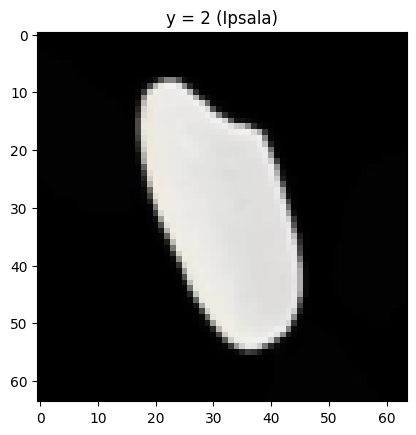

In [12]:
show_image(test_set[800])

In [13]:
class RiceCNNClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding=2)
        self.bn1 = nn.BatchNorm2d(num_features=32)
        self.pool1 = nn.MaxPool2d(kernel_size=2)

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        self.pool2 = nn.MaxPool2d(kernel_size=2)

        self.lin1 = nn.Linear(in_features=64*16*16, out_features=32)
        self.bn3 = nn.BatchNorm1d(num_features=32)

        self.lin2 = nn.Linear(in_features=32, out_features=5)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = torch.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = torch.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0), -1)

        x = self.lin1(x)
        x = self.bn3(x)
        x = torch.relu(x)

        return x

In [14]:
model = RiceCNNClassifier()
model.to(device)

RiceCNNClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (lin1): Linear(in_features=16384, out_features=32, bias=True)
  (bn3): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lin2): Linear(in_features=32, out_features=5, bias=True)
)

In [15]:
LEARNING_RATE = 0.001
EPOCHS = 5

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [16]:
train_loader = DataLoader(dataset=train_set, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=128)
test_loader = DataLoader(dataset=test_set, batch_size=128)

In [17]:
def train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS):
    train_acc = []
    train_loss = []
    val_acc = []
    val_loss = []

    for epoch in range(EPOCHS):
        print(f'Epoch {epoch + 1}:')

        cum_loss = correct = 0
        model.train()
        for x, y in tqdm(train_loader, desc='Training', colour='#FFEA00'):
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, y_ = torch.max(z, 1)
            correct += (y_ == y).sum().item()
            loss = criterion(z, y)
            cum_loss += loss.data.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        acc = correct / len(train_set)
        train_acc.append(acc)

        loss = cum_loss / len(train_set)
        train_loss.append(loss)

        print(f'Training Loss = {loss} | Accuracy = {acc}')

        cum_loss = correct = 0
        model.eval()
        with torch.no_grad():
            for x, y in tqdm(val_loader, desc='Validation', colour='#93C572'):
                x, y = x.to(device), y.to(device)
                z = model(x)
                _, y_ = torch.max(z, 1)
                correct += (y_ == y).sum().item()
                loss = criterion(z, y)
                cum_loss += loss.data.item()
            acc = correct / len(val_set)
            val_acc.append(acc)

            loss = cum_loss / len(val_set)
            val_loss.append(loss)

            print(f'Validation Loss = {loss} | Accuracy = {acc}', end='\n\n')

    return train_acc, train_loss, val_acc, val_loss

In [18]:
train_acc, train_loss, val_acc, val_loss = train_model(model, train_loader, val_loader, criterion, optimizer, EPOCHS)

Epoch 1:


Training: 100%|██████████| 469/469 [01:16<00:00,  6.12it/s]


Training Loss = 0.010666321965058645 | Accuracy = 0.9717666666666667


Validation: 100%|██████████| 59/59 [00:08<00:00,  6.68it/s]


Validation Loss = 0.007142333213488261 | Accuracy = 0.9905333333333334

Epoch 2:


Training: 100%|██████████| 469/469 [01:14<00:00,  6.32it/s]


Training Loss = 0.004929319575925668 | Accuracy = 0.9925166666666667


Validation: 100%|██████████| 59/59 [00:08<00:00,  6.63it/s]


Validation Loss = 0.004162032345930735 | Accuracy = 0.9890666666666666

Epoch 3:


Training: 100%|██████████| 469/469 [01:10<00:00,  6.61it/s]


Training Loss = 0.0026414083652198314 | Accuracy = 0.9937666666666667


Validation: 100%|██████████| 59/59 [00:08<00:00,  7.35it/s]


Validation Loss = 0.0021443933188915252 | Accuracy = 0.9952

Epoch 4:


Training: 100%|██████████| 469/469 [01:10<00:00,  6.70it/s]


Training Loss = 0.0015948542311787605 | Accuracy = 0.9953333333333333


Validation: 100%|██████████| 59/59 [00:08<00:00,  7.08it/s]


Validation Loss = 0.001246940133968989 | Accuracy = 0.9948

Epoch 5:


Training: 100%|██████████| 469/469 [01:09<00:00,  6.72it/s]


Training Loss = 0.0010534375590582688 | Accuracy = 0.99625


Validation: 100%|██████████| 59/59 [00:08<00:00,  6.76it/s]

Validation Loss = 0.0011278708070516586 | Accuracy = 0.996



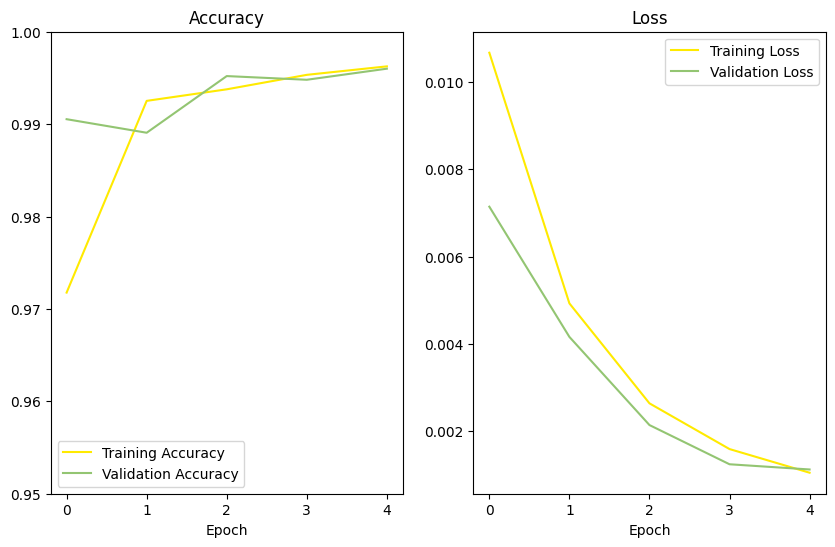

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 6))


axes[0].plot(train_acc, color='#FFEA00', label='Training Accuracy')
axes[0].plot(val_acc, color='#93C572', label='Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_title('Accuracy')
axes[0].set_ylim(0.95, 1)
axes[0].legend()

axes[1].plot(train_loss, color='#FFEA00', label='Training Loss')
axes[1].plot(val_loss, color='#93C572', label='Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_title('Loss')
axes[1].legend()

fig.show()

In [68]:
def test_model(model, test_loader, criterion, optimizer):
    true_list = []
    pred_list = []
    correct = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(test_loader, desc='Testing', colour='#A020F0'):
            x, y = x.to(device), y.to(device)
            z = model(x)
            _, y_ = torch.max(z, 1)
            true_list.extend(y.cpu().flatten().tolist())
            pred_list.extend(y_.cpu().flatten().tolist())
            correct += (y_ == y).sum().item()

    acc = correct / len(test_set)
    print(f'\nTest Accuracy = {acc}')
    #true_list = [a.sqeeze().to_list() for a in true_list]
    #pred_list = [a.sqeeze().to_list() for a in pred_list]
    return true_list , pred_list

In [69]:
y, predictions = test_model(model, test_loader, criterion, optimizer)

Testing: 100%|██████████| 59/59 [00:08<00:00,  7.08it/s]


Test Accuracy = 0.9964


In [76]:
print(classification_report(y, predictions, digits=4))

              precision    recall  f1-score   support

           0     0.9979    0.9917    0.9948      1453
           1     0.9980    0.9948    0.9964      1529
           2     0.9993    1.0000    0.9997      1502
           3     0.9909    0.9967    0.9938      1528
           4     0.9960    0.9987    0.9973      1488

    accuracy                         0.9964      7500
   macro avg     0.9964    0.9964    0.9964      7500
weighted avg     0.9964    0.9964    0.9964      7500



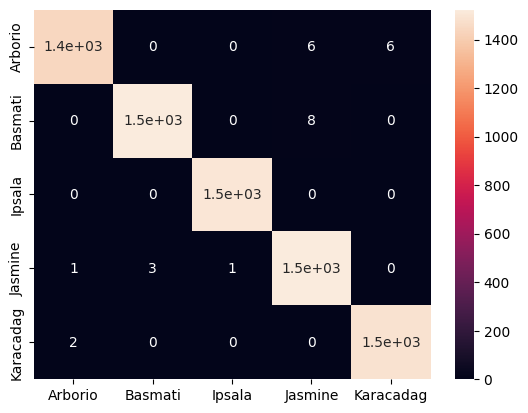

In [84]:
confusion_matrix_df = pd.DataFrame(
    confusion_matrix(y, predictions),
    columns=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag'],
    index=['Arborio', 'Basmati', 'Ipsala', 'Jasmine', 'Karacadag']
)
sns.heatmap(confusion_matrix_df, annot=True, xticklabels=True, yticklabels=True)
plt.show()